In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv
import multivelo as mv

In [2]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.left'] = True

In [4]:
multivelo = anndata.read_h5ad(
    '../data/Human_brain/multivelo_result.h5ad')
celldancer = anndata.read_h5ad(
    '../data/Human_brain/celldancer.h5ad')

In [5]:
multivelo.layers['Mc'] = multivelo.layers['ATAC']
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']

In [6]:
adata_out = anndata.read_h5ad(
    '../data/Human_brain/adata_out.moflow.mvstyle.h5ad')

In [7]:
pseudotime_ = np.zeros(adata_out.n_obs)
pseudotime_[np.argsort(adata_out.obs['velo_s_pseudotime'])] = np.arange(adata_out.n_obs)
adata_out.obs['velo_s_pseudotime_'] = pseudotime_/adata_out.n_obs

In [8]:
labels = pd.read_csv('../temps/250208_humanbrain_cluster.csv', index_col=0)


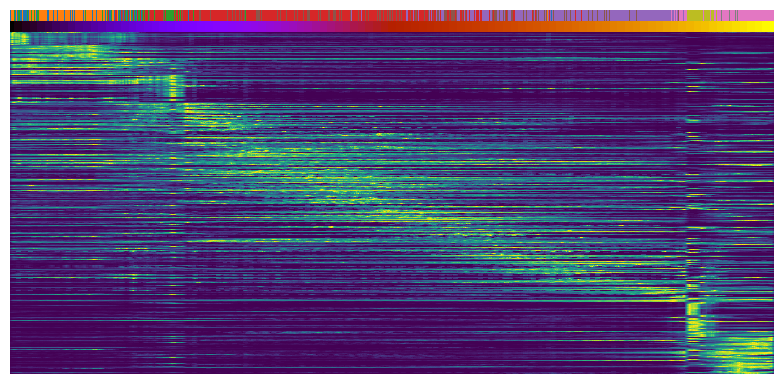

In [9]:
scv.pl.heatmap(adata_out,
               var_names=labels.index,
               sort=False,
               sortby='velo_s_pseudotime_',
               color_map='viridis',
               col_color=['celltype_new', 'velo_s_pseudotime_'],
               palette='gnuplot',
                yticklabels=False,
                #save='../figures/fig2E.heatmap.pdf',
                dpi=150
                
               )

In [10]:
model = np.zeros(adata_out.n_vars).astype(str)
on_ = np.zeros(adata_out.n_vars)
off_ = np.zeros(adata_out.n_vars)
m1_ = np.zeros(adata_out.n_vars)
m2_ = np.zeros(adata_out.n_vars)

for i, g in enumerate(adata_out.var_names):
    c = adata_out[:, g].layers['c'].ravel()
    u = adata_out[:, g].layers['u'].ravel()
    s = adata_out[:, g].layers['s'].ravel()
    
    vc = adata_out[:, g].layers['velo_c'].ravel()
    vs = adata_out[:, g].layers['velo_s'].ravel()
    vu = adata_out[:, g].layers['velo_u'].ravel()
    
    w_non_zero = ((c >= 0.1 * np.max(c)) &
                    (u >= 0.1 * np.max(u)) &
                    (s >= 0.1 * np.max(s)))
    u_non_zero = u[w_non_zero]
    s_non_zero = s[w_non_zero]
    wu = u >= np.percentile(u_non_zero, 90)
    ws = s >= np.percentile(s_non_zero, 90)
    
    #ww = wu|ws&down
    ww = wu|ws
    ww |= (vu * vs >= 0)
    
    on_[i] = np.mean((vu[w_non_zero]>0)&(vs[w_non_zero]>0))
    off_[i] = np.mean((vu[w_non_zero]<0)&(vs[w_non_zero]<0))
    m1_[i] = np.mean((vc[ww]<0)&(vu[ww]>0))
    m2_[i] = np.mean((vc[ww]>0)&(vu[ww]<0))
    #m1_[i] = np.mean((vc[ww]<0))
    #m2_[i] = np.mean((vc[ww]>=0))
    

    

In [11]:
temp = pd.DataFrame({'on': on_, 'off': off_,
                     'm1': m1_, 'm2': m2_,},
                    index=adata_out.var_names)
temp['label'] = labels['label']

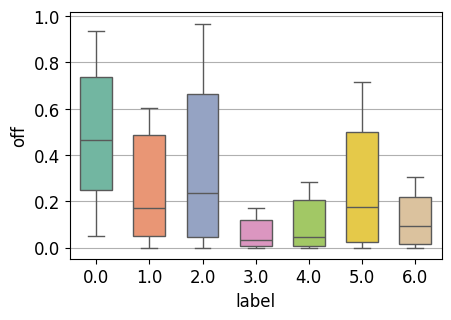

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
sns.boxplot(temp, y='off', x='label', fill=True, palette='Set2',
            width=.6, whis=.5, showfliers=False,
)
ax.grid(axis='y')
fig.savefig('../figures/fig3B_cluster.pdf')

In [20]:
temp['m1'] = temp['m1']/(temp['m1'] + temp['m2'])
temp['m2'] = temp['m2']/(temp['m1'] + temp['m2'])

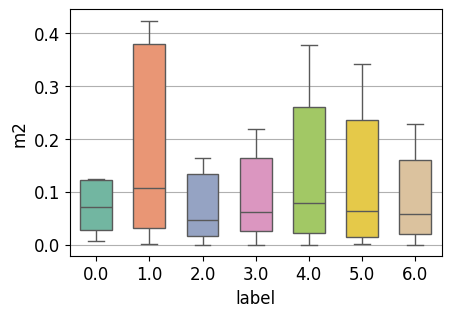

In [22]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
sns.boxplot(temp, y='m2', x='label', fill=True, palette='Set2',
            width=.6, whis=.5, showfliers=False,
)
ax.grid(axis='y')
fig.savefig('../figures/fig3B_cluster_m2.pdf')

In [12]:
fitstate_cu = np.zeros_like(adata_out.layers['c'])

fitstate_cu[(adata_out.layers['velo_c']>0) & (adata_out.layers['velo_u']<0)] = 1
fitstate_cu[(adata_out.layers['velo_c']>0) & (adata_out.layers['velo_u']>0)] = 2
fitstate_cu[(adata_out.layers['velo_c']<0) & (adata_out.layers['velo_u']>0)] = 3
fitstate_cu[(adata_out.layers['velo_c']<0) & (adata_out.layers['velo_u']<0)] = 4
fitstate_cu[(adata_out.layers['c']<0.05) & (adata_out.layers['u']<0.05) & (adata_out.layers['s']<0.05)] = 0

In [13]:
fitstate_us = np.zeros_like(adata_out.layers['c'])
fitstate_us[(adata_out.layers['velo_u']>0) & (adata_out.layers['velo_s']<0)] = 1
fitstate_us[(adata_out.layers['velo_u']>0) & (adata_out.layers['velo_s']>0)] = 2
fitstate_us[(adata_out.layers['velo_u']<0) & (adata_out.layers['velo_s']>0)] = 3
fitstate_us[(adata_out.layers['velo_u']<0) & (adata_out.layers['velo_s']<0)] = 4
fitstate_us[(adata_out.layers['c']<0.05) & (adata_out.layers['u']<0.05) & (adata_out.layers['s']<0.05)] = 0


In [14]:
adata_out.layers['fit_state_cu'] = fitstate_cu
adata_out.layers['fit_state_us'] = fitstate_us

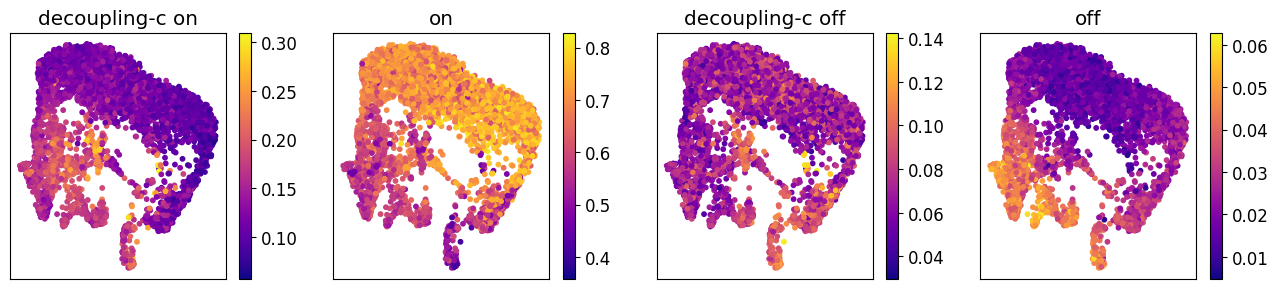

In [25]:
fig, axes = plt.subplots(1,4, figsize=(4*4, 3.2))
for i, title in enumerate(['decoupling-c on', 'on', 'decoupling-c off', 'off']):
    im = axes[i].scatter(
        x = adata_out.obsm['X_umap'][:, 0],
        y = adata_out.obsm['X_umap'][:, 1],
        c= np.mean(adata_out.layers['fit_state_cu']==i+1, axis=1), s=10,
        cmap='plasma'
        )
    plt.colorbar(im)
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(title)
fig.savefig('../figures/fig3A.pdf')


In [9]:
gene_list = ['PDGFRA', 'MAP3K1']

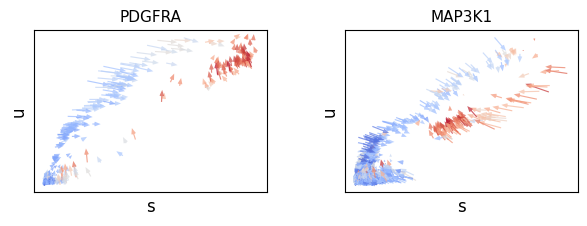

In [27]:
fig, axes = mf.scatter_gene(adata_out, gene_list=gene_list, 
                            color_by='c', velocity_arrows=True)
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig3C_c.pdf')

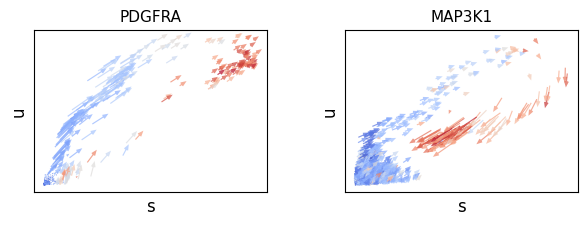

In [11]:
fig, axes = mf.scatter_gene(multivelo, gene_list=gene_list, 
                            color_by='Mc', velocity_arrows=True)
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig3C_c_mv.pdf')

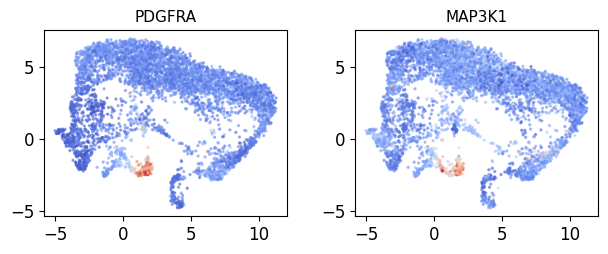

In [12]:
fig, axes = mf.scatter_cell(adata_out, gene_list=gene_list, 
                            color_by='c')
fig.savefig('../figures/fig3C_c_S_c.pdf')

In [9]:
from scipy.ndimage import uniform_filter1d
from fastdtw import fastdtw

In [15]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def smooth(x, size=3):# smoothing
    return uniform_filter1d(x, size=size)
def pad_ends(x):# Add zero to both ends
    return np.concatenate([[0], x, [0]])

def bin_and_average(x, time, n_bins=20):
    bins = np.linspace(np.min(time), np.max(time), n_bins + 1)
    binned = np.digitize(time, bins) - 1
    out = np.array([np.mean(x[binned == i]) for i in range(n_bins)])
    return out


def get_dtw(adata, gene, genetime=False, timekey = 'velo_s_pseudotime_', n_bins=20):
    #if genetime:
    #    adata_ = adata[np.argsort(adata[:, gene].layers[timekey].ravel())]
    #else:
    #    adata_ = adata[np.argsort(adata.obs[timekey])]
    #c = adata_[:, gene].layers['Mc'].ravel()
    #u = adata_[:, gene].layers['Mu'].ravel()
    #s = adata_[:, gene].layers['Ms'].ravel()
    
    if genetime:
        time = adata[:, gene].layers[timekey].ravel()
    else:
        time = adata.obs[timekey].values
    time = np.clip(time, 0, np.quantile(time, 0.95))

    c = adata[:, gene].layers['Mc'].ravel()
    u = adata[:, gene].layers['Mu'].ravel()
    s = adata[:, gene].layers['Ms'].ravel()
    
    c = bin_and_average(c, time, n_bins)
    u = bin_and_average(u, time, n_bins)
    s = bin_and_average(s, time, n_bins)


    c_norm = normalize(c)
    u_norm = normalize(u)
    s_norm = normalize(s)

    c_smooth = smooth(c_norm)
    u_smooth = smooth(u_norm)
    s_smooth = smooth(s_norm)

    c_pad = pad_ends(c_smooth)
    u_pad = pad_ends(u_smooth)
    s_pad = pad_ends(s_smooth)
    
    #print(c_pad.shape, s_pad.shape)
    #print(np.any(np.isnan(c_pad)), np.any(np.isinf(c_pad), np.any(np.isnan(s_pad)), np.any(np.isinf(s_pad))))
    #print(c_pad)
    time_pad = np.linspace(0, 1, len(c_pad))


    distance_c_s, path_c_s = fastdtw(c_pad, s_pad, )
    distance_u_s, path_u_s = fastdtw(u_pad, s_pad, )

    time_lag_c_s = [time_pad[j] - time_pad[i] for i, j in path_c_s]
    time_lag_u_s = [time_pad[j] - time_pad[i] for i, j in path_u_s]
    return(time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s)

def plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s, 
         axvspan='clusterbig', legend=['Astro', 'Oligo', 'Exc'],
         figsave=None):

    fig, axs = plt.subplots(2, 1, figsize=(4.8, 3.2), sharex=True)

    # Top: c vs s
    axs[0].plot(time_pad, c_pad, label='c', color='#102E50')
    axs[0].plot(time_pad, u_pad, label='u', color='#F5C45E')
    axs[0].plot(time_pad, s_pad, label='s', color='#BE3D2A')
    
    for i, j in path_c_s[::3]:  # skip some lines for clarity
        axs[0].plot([time_pad[i], time_pad[j]], [c_pad[i], s_pad[j]], 'k--', linewidth=0.5)
    for i, j in path_u_s[::3]:
        axs[0].plot([time_pad[i], time_pad[j]], [u_pad[i], s_pad[j]], 'k--', linewidth=0.5)
    
    axs[0].set_ylabel("Norm values")
    axs[0].legend()
    axs[0].set_title("DTW Alignment")

    # Middle: u vs s
    #axs[1].plot(time_pad, u_pad, label='u', color='#F5C45E')
    #axs[1].plot(time_pad, s_pad, label='s', color='#BE3D2A')
    #for i, j in path_u_s[::3]:
    #    axs[1].plot([time_pad[i], time_pad[j]], [u_pad[i], s_pad[j]], 'k--', linewidth=0.5)
    #axs[1].set_ylabel("Norm values")
    #axs[1].legend()
    #axs[1].set_title("DTW Alignment: u vs s")

    # Bottom: time lag
    axs[1].plot([time_pad[i] for i, _ in path_c_s], time_lag_c_s, label='c-s lag', color='#3E3F5B')
    axs[1].plot([time_pad[i] for i, _ in path_u_s], time_lag_u_s, label='u-s lag', color='#8AB2A6')
    axs[1].axhline(0, color='gray', linestyle='--')
    axs[1].set_ylabel("Time lag")
    axs[1].set_xlabel("Time")
    axs[1].legend()
    #axs[2].set_title("Instantaneous Time Lags")
    
    fig.suptitle(gene)

    plt.tight_layout()
    plt.show()
    
    if figsave is not None:
        fig.savefig(figsave)




In [16]:
adata_out_ = adata_out[adata_out.obs['celltype_new'].isin(['RG', 'Cyc. Prog.', 'mGPC/OPC'])]
multivelo_ = multivelo[multivelo.obs['celltype_new'].isin(['RG', 'Cyc. Prog.', 'mGPC/OPC'])]

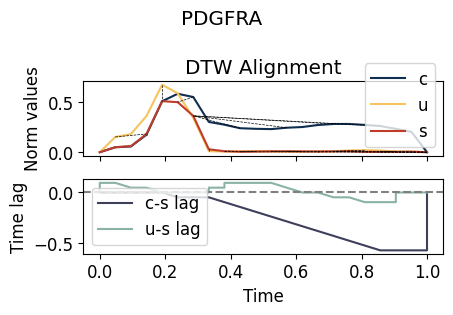

In [17]:

time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, 
                                                                                       'PDGFRA')
plot('PDGFRA', time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     axvspan=None, figsave='../figures/fig3F_pdgfra_mf.pdf'
)


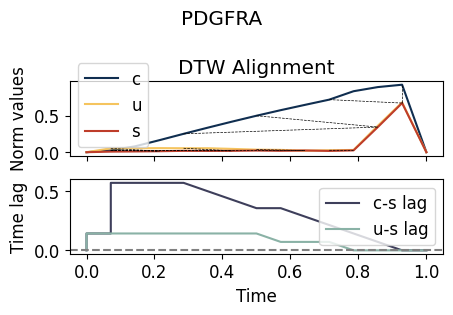

In [18]:
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(multivelo, 'PDGFRA', True, 'fit_t', n_bins=13)
plot('PDGFRA', time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig3F_pdgfra_mv.pdf'
)
     

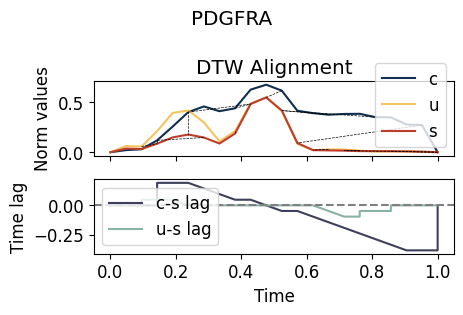

In [19]:
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(multivelo, 'PDGFRA', 
                                                                                       False, 'latent_time')
plot('PDGFRA', time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig3F_pdgfra_mv_global.pdf'
)

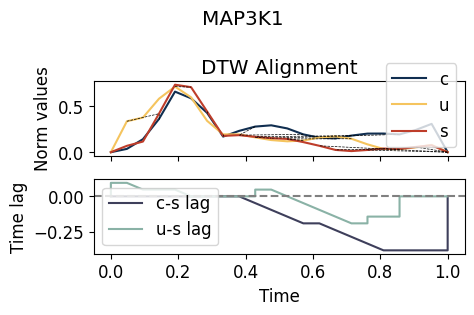

In [20]:

time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out,
                                                                                       'MAP3K1')
plot('MAP3K1', time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig3F_map3k1_mf.pdf'
)

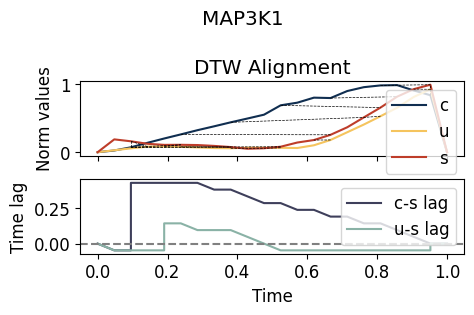

In [21]:
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(multivelo, 
                                                                                       'MAP3K1', True, 'fit_t')
plot('MAP3K1', time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig3F_map3k1_mv.pdf'
)

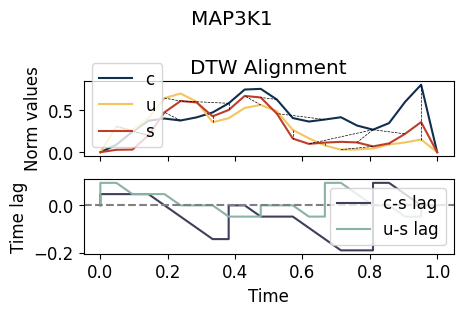

In [22]:
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(multivelo, 
                                                                                       'MAP3K1', False, 'latent_time')
plot('MAP3K1', time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
     figsave='../figures/fig3F_map3k1_mv_global.pdf'
)

In [23]:
from scipy.interpolate import interp1d

def resample_timelag(timelag, n=22):
    x_old = np.linspace(0, 1, len(timelag))
    x_new = np.linspace(0, 1, n)
    f = interp1d(x_old, timelag, kind='linear', fill_value='extrapolate')
    return f(x_new)

In [24]:
nangene = []
time_lag_c_s_ = []
time_lag_u_s_ = []

c_pad_ = []
u_pad_ = []
s_pad_ = []

for g in adata_out.var_names:
    try:
        
        time_pad, c_pad, u_pad, s_pad, time_lag_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(adata_out, g, timekey='velo_s_pseudotime_')
        time_lag_c_s_.append(resample_timelag(time_lag_c_s))
        time_lag_u_s_.append(resample_timelag(time_lag_u_s))
        
        c_pad_.append(c_pad)
        u_pad_.append(u_pad)
        s_pad_.append(s_pad)
        
    except:
        nangene.append(g)
indices_mf = np.setdiff1d(adata_out.var_names, np.array(nangene))

time_lag_c_s_mf = pd.DataFrame(time_lag_c_s_, index=indices_mf)
time_lag_u_s_mf = pd.DataFrame(time_lag_u_s_, index=indices_mf)

In [25]:
nangene = []
time_lag_c_s_ = []
time_lag_u_s_ = []

c_pad_ = []
u_pad_ = []
s_pad_ = []

for g in multivelo.var_names:
    try:
        
        time_pad, c_pad, u_pad, s_pad, time_lag_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(
            multivelo, g, timekey='fit_t', genetime=True)
        time_lag_c_s_.append(resample_timelag(time_lag_c_s))
        time_lag_u_s_.append(resample_timelag(time_lag_u_s))
        
        c_pad_.append(c_pad)
        u_pad_.append(u_pad)
        s_pad_.append(s_pad)
        
    except:
        nangene.append(g)
indices_mv = np.setdiff1d(multivelo.var_names, np.array(nangene))

time_lag_c_s_mv = pd.DataFrame(time_lag_c_s_, index=indices_mv)
time_lag_u_s_mv = pd.DataFrame(time_lag_u_s_, index=indices_mv)

In [26]:
nangene = []
time_lag_c_s_ = []
time_lag_u_s_ = []

c_pad_ = []
u_pad_ = []
s_pad_ = []

for g in multivelo.var_names:
    try:
        
        time_pad, c_pad, u_pad, s_pad, time_lag_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(
            multivelo, g, timekey='latent_time', genetime=False)
        time_lag_c_s_.append(resample_timelag(time_lag_c_s))
        time_lag_u_s_.append(resample_timelag(time_lag_u_s))
        
        c_pad_.append(c_pad)
        u_pad_.append(u_pad)
        s_pad_.append(s_pad)
        
    except:
        nangene.append(g)
indices_mv = np.setdiff1d(multivelo.var_names, np.array(nangene))

time_lag_c_s_mv_g = pd.DataFrame(time_lag_c_s_, index=indices_mv)
time_lag_u_s_mv_g = pd.DataFrame(time_lag_u_s_, index=indices_mv)

In [27]:
timelag_mv = time_lag_c_s_mv * time_lag_c_s_mv_g.loc[time_lag_c_s_mv.index]

In [28]:
sign_match = np.sign(time_lag_c_s_mv.values) * np.sign(time_lag_c_s_mv_g.loc[time_lag_c_s_mv.index].values)

In [70]:
sign_match_opposite = sign_match[np.sum(sign_match < 0, axis=1) >= 15]


In [71]:
len(sign_match_opposite)

129

In [64]:
num_sign_oppo = []
for i in [0, 5, 10, 15, 20]:
    num_sign_oppo.append(len(sign_match[np.sum(sign_match < 0, axis=1) >= i]))
    

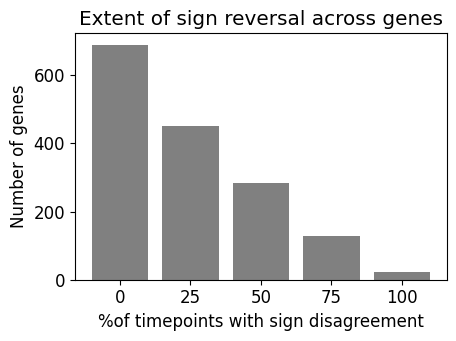

In [72]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
ax.bar(x=[f'{n}' for n in [0, 25, 50, 75, 100]], height=num_sign_oppo, color='grey')
ax.set_title("Extent of sign reversal across genes")
ax.set_xlabel("%of timepoints with sign disagreement")
ax.set_ylabel("Number of genes")
fig.savefig('../figures/fig3G_bar.pdf')

In [53]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mylist', ['crimson', 'lightsteelblue'], N=2)

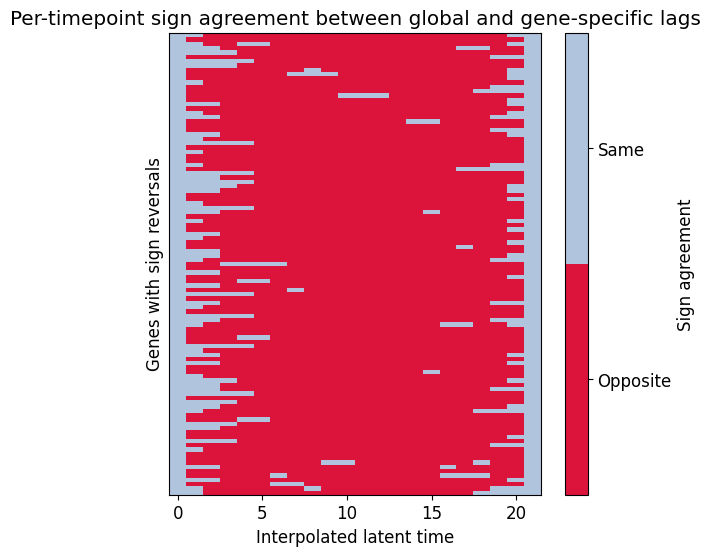

In [57]:
plt.figure(figsize=(6, 6))
plt.imshow(sign_match_opposite, cmap=cmap, aspect='auto', interpolation='none')
cbar = plt.colorbar(label='Sign agreement', 
             )
cbar.set_ticks([-0.5, 0.5])
cbar.set_ticklabels(['Opposite', 'Same'])

plt.xlabel('Interpolated latent time')
plt.ylabel('Genes with sign reversals')
plt.title('Per-timepoint sign agreement between global and gene-specific lags')
plt.yticks([])
plt.savefig('../figures/fig3G_heatmap.pdf')

In [34]:
pos_rate_global = (time_lag_c_s_mv_g.loc[:,1: 20] >=0).sum(axis=1) / 20
neg_rate_global = (time_lag_c_s_mv_g.loc[:,1: 20] >=0).sum(axis=1) / 20
pos_rate_gene = (time_lag_c_s_mv.loc[:,1:20] >=0).sum(axis=1) / 20
neg_rate_gene = (time_lag_c_s_mv.loc[:,1:20] >=0).sum(axis=1) / 20


In [35]:
df = pd.DataFrame({
    'Gene': pos_rate_gene.index,
    'pos_rate_gene': pos_rate_gene.values,
    'pos_rate_global': pos_rate_global[pos_rate_gene.index].values
})


In [37]:
bins = np.linspace(0, 1, 21)  
heatmap_data, xedges, yedges = np.histogram2d(
    df['pos_rate_gene'], df['pos_rate_global'],
    bins=(bins, bins)
)

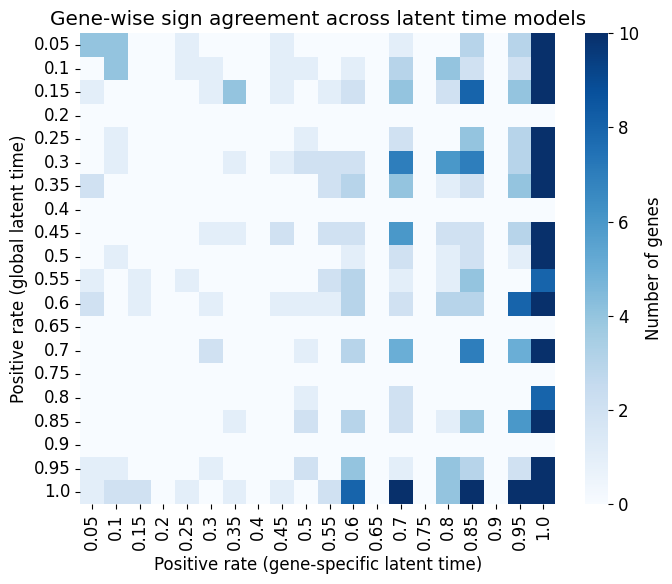

In [41]:
plt.figure(figsize=(7, 6))
sns.heatmap(
    heatmap_data.T, 
    xticklabels=np.round(bins[1:], 2),
    yticklabels=np.round(bins[1:], 2),
    cmap="Blues",
    cbar_kws={'label': 'Number of genes'},
    vmax=10
)
plt.xlabel("Positive rate (gene-specific latent time)")
plt.ylabel("Positive rate (global latent time)")
plt.title("Gene-wise sign agreement across latent time models")
plt.tight_layout()
plt.show()

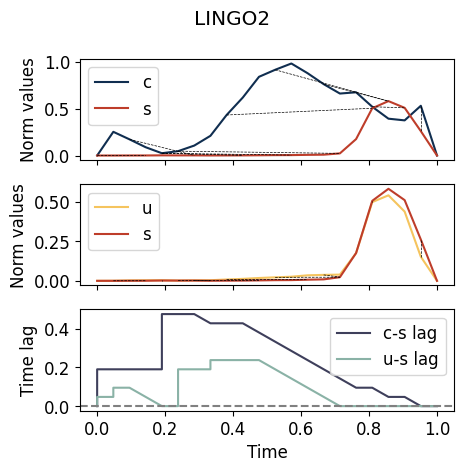

In [56]:
gene = 'LINGO2'
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(
    multivelo, gene, False, 'latent_time')
plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
)

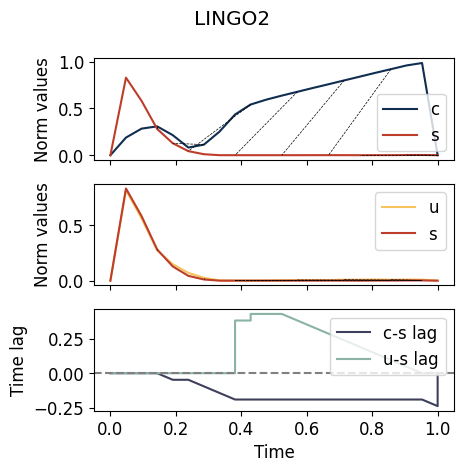

In [57]:
time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s= get_dtw(
    multivelo, gene,True, 'fit_t')
plot(gene, time_pad, c_pad, u_pad, s_pad, path_c_s, path_u_s, time_lag_c_s, time_lag_u_s,
)

(<Figure size 320x270 with 1 Axes>,
 array([[<Axes: title={'center': 'LINGO2'}, xlabel='s', ylabel='u'>]],
       dtype=object))

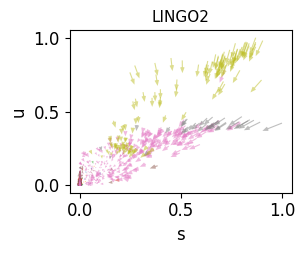

In [58]:
mf.scatter_gene(adata_out, gene, color_by='celltype_new', velocity_arrows=True, by='us')

(<Figure size 320x270 with 1 Axes>,
 array([[<Axes: title={'center': 'LINGO2'}, xlabel='s', ylabel='u'>]],
       dtype=object))

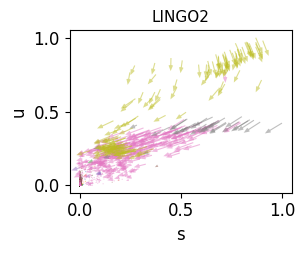

In [59]:
mf.scatter_gene(multivelo, gene, color_by='celltype_new', velocity_arrows=True)


In [31]:
adata_rna_ = anndata.read_h5ad('../data/Human_brain/adata_rna_wmtg.h5ad')


saving figure to file ../figures/fig3H.pdf


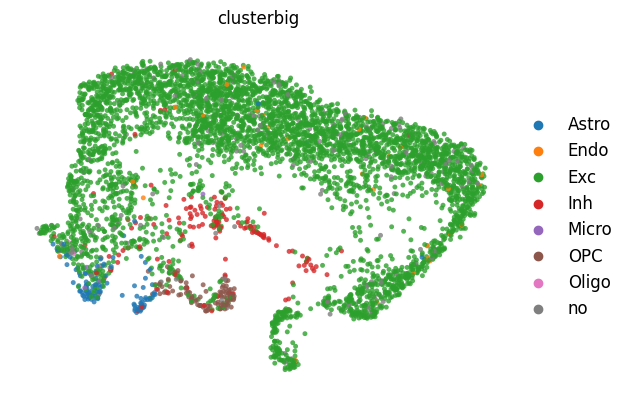

In [48]:
scv.pl.scatter(adata_rna_,
               color='clusterbig', ylim=(-6, 8), xlim=(-6, 12),
               legend_loc='right margin', s=50, alpha=.8,
               save='../figures/fig3H.pdf')